# Gesture Recognition
This project aimed to recognize gestures using 3D CNN models and explored multiple model variations before employing transfer learning using MobileNet with an RNN layer. 

In [1]:
import numpy as np
import os
import imageio
from skimage.transform import resize, rescale
import datetime
import os

import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
print(tf.__version__)
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
tf.random.set_seed(30)


2.7.0


#### setting up required paths

In [3]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
gestures = 5


In [4]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)


# training sequences = 663
# validation sequences = 100


#### generic function for plotting loss accuracy

In [5]:
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

#### generic function for calculating steps

In [6]:
def calculate_steps(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return steps_per_epoch,validation_steps

In [7]:
def model_callbacks(folder_name):
    model_name = str(folder_name) + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
   
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) # write the REducelronplateau code here

    return [checkpoint, LR]   

#### Image generator function

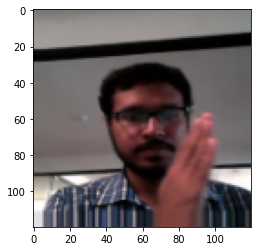

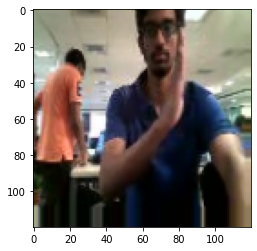

In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    zoom_range=0.1,
    zca_whitening=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

## Test code start
#360 by 360
image1 = imageio.imread("/home/datasets/Project_data/val/WIN_20180907_15_30_06_Pro_Right Swipe_new/WIN_20180907_15_30_06_Pro_00029.png")
#160 by 120
image2 = imageio.imread("/home/datasets/Project_data/val/WIN_20180926_17_56_52_Pro_Right_Swipe_new/WIN_20180926_17_56_52_Pro_00029.png")
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes                    
#print(image1.shape, image2.shape)
image1 = resize(image1, (120, 120), anti_aliasing=True)
image1 = datagen.random_transform(image1)                   
plt.imshow(image1)
plt.show()
image2 = resize(image2, (120, 120), anti_aliasing=True)
image2 = datagen.random_transform(image2)                 
plt.imshow(image2)
plt.show()

#### generator function with following parameters
- source_path
- folder_list
- batch_size
- num_images
- height
- width
- augment

In [9]:
def generate(source_path, folder_list, batch_size, num_images=20, height=120, width=120, augment=False):
    #print( 'Source path = ', source_path, '; batch size =', batch_size)
    total_frames = 30

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        #img_idx = sorted(rn.sample(range(0, total_frames), num_images)) #create a list of image numbers you want to use for a particular video
        img_idx = np.round(np.linspace(0,total_frames-1,num_images)).astype(int) #create a list of image numbers you want to use for a particular video

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data   = np.zeros((batch_size, num_images, height, width, 3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output           

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes                    
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)

                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image                  
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size):
            remaining_batch_size = len(t)%batch_size
            batch_data   = np.zeros((remaining_batch_size, num_images, height, width,3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output           

            for folder in range(remaining_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)                          
                    
                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image
                    #batch_data[folder,idx,:,:,0] = (image[...,0] - image[...,0].min())/(image[...,0].max() - image[...,0].min())#normalise and feed in the image
                    #batch_data[folder,idx,:,:,1] = (image[...,1] - image[...,1].min())/(image[...,1].max() - image[...,1].min())#normalise and feed in the image
                    #batch_data[folder,idx,:,:,2] = (image[...,2] - image[...,2].min())/(image[...,2].max() - image[...,2].min())#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [10]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers

### Experiment 1 base model

In [12]:
# Common utility to create conv 3D models
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (3, 3, 3), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))    
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(gestures))
    model.add(Activation('softmax'))

    opt = optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    
    return model

In [30]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 25
# batch size = 10
# num_frames per video = 30
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_19 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_18 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                            

In [31]:
callbacks_list = model_callbacks("model_conv3D_1")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [32]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_420/2636822326.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/25


2024-10-01 14:26:38.423744: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


67/67 [==============================] - ETA: 0s - loss: 1.5617 - categorical_accuracy: 0.4615
Epoch 00001: val_loss improved from inf to 3.96854, saving model to model_conv3D_1_2024-10-0114_23_12.581878/model-00001-1.56171-0.46154-3.96854-0.21000.h5
67/67 [==============================] - 161s 2s/step - loss: 1.5617 - categorical_accuracy: 0.4615 - val_loss: 3.9685 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 1.2863 - categorical_accuracy: 0.5189
Epoch 00002: val_loss did not improve from 3.96854
67/67 [==============================] - 160s 2s/step - loss: 1.2863 - categorical_accuracy: 0.5189 - val_loss: 10.0013 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 0.9384 - categorical_accuracy: 0.6365
Epoch 00003: val_loss did not improve from 3.96854
67/67 [==============================] - 158s 2s/step - loss: 0.9384 - categorical_accuracy: 0.6365 

#### Experiment 2

In [16]:
num_epochs = 20 # choose the number of epochs
#print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# batch size = 10
# num_frames per video = 20
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 20, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 60, 60, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 60, 60, 32)    13856     
                                                                 
 activatio

2024-10-02 05:59:30.840129: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-10-02 05:59:30.840208: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3f:00.0, compute capability: 7.5


In [17]:
callbacks_list = model_callbacks("model_conv3D_2")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [18]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20


2024-10-02 06:00:07.314710: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


67/67 [==============================] - ETA: 0s - loss: 1.5178 - categorical_accuracy: 0.4434
Epoch 00001: val_loss improved from inf to 3.36926, saving model to model_conv3D_2_2024-10-0205_58_50.750794/model-00001-1.51780-0.44344-3.36926-0.16000.h5
67/67 [==============================] - 124s 2s/step - loss: 1.5178 - categorical_accuracy: 0.4434 - val_loss: 3.3693 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.0586 - categorical_accuracy: 0.5837
Epoch 00002: val_loss did not improve from 3.36926
67/67 [==============================] - 104s 2s/step - loss: 1.0586 - categorical_accuracy: 0.5837 - val_loss: 4.6982 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.9844 - categorical_accuracy: 0.6169
Epoch 00003: val_loss did not improve from 3.36926
67/67 [==============================] - 112s 2s/step - loss: 0.9844 - categorical_accuracy: 0.6169 -

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


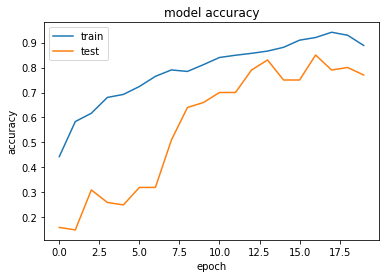

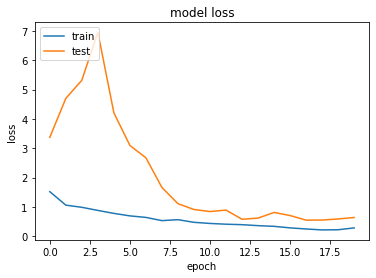

In [19]:
plot_loss_accuracy(history)

#### Experiment 3

In [20]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 160
width = 160

model = conv3D(num_images=num_frames, height=160, width=160)

print (model.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 30
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_7 (Activation)   (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 30, 160, 160, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 15, 80, 80, 32)    13856     
                                                            

In [21]:
callbacks_list = model_callbacks("model_conv3D_3")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames, height=160, width=160)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames, height=160, width=160)

In [22]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.5629 - categorical_accuracy: 0.4540
Epoch 00001: val_loss improved from inf to 4.17934, saving model to model_conv3D_3_2024-10-0205_58_50.750794/model-00001-1.56291-0.45400-4.17934-0.16000.h5
67/67 [==============================] - 189s 3s/step - loss: 1.5629 - categorical_accuracy: 0.4540 - val_loss: 4.1793 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.1714 - categorical_accuracy: 0.5370
Epoch 00002: val_loss improved from 4.17934 to 2.74363, saving model to model_conv3D_3_2024-10-0205_58_50.750794/model-00002-1.17144-0.53695-2.74363-0.29000.h5
67/67 [==============================] - 179s 3s/step - loss: 1.1714 - categorical_accuracy: 0.5370 - val_loss: 2.7436 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.0021 - categorical_accuracy: 0.6169
Epoch 00003: val_loss did not im

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


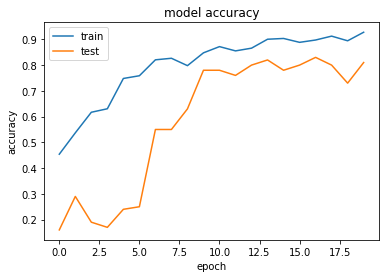

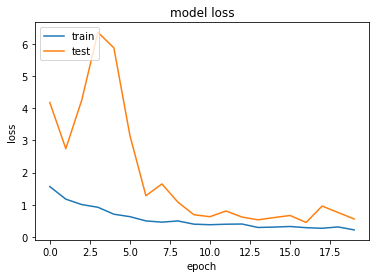

In [23]:
plot_loss_accuracy(history)


#### Experiment 4

In [24]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 160
width = 160

model = conv3D(num_images=num_frames, height=160, width=160)

print (model.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 20
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_14 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 10, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                                            

In [25]:
callbacks_list = model_callbacks("model_conv3D_4")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames, height=160, width=160)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames, height=160, width=160)

In [26]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.7104 - categorical_accuracy: 0.3906
Epoch 00001: val_loss improved from inf to 2.37333, saving model to model_conv3D_4_2024-10-0205_58_50.750794/model-00001-1.71040-0.39065-2.37333-0.26000.h5
67/67 [==============================] - 122s 2s/step - loss: 1.7104 - categorical_accuracy: 0.3906 - val_loss: 2.3733 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.3577 - categorical_accuracy: 0.4736
Epoch 00002: val_loss did not improve from 2.37333
67/67 [==============================] - 120s 2s/step - loss: 1.3577 - categorical_accuracy: 0.4736 - val_loss: 3.2725 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.1864 - categorical_accuracy: 0.5551
Epoch 00003: val_loss improved from 2.37333 to 2.19258, saving model to model_conv3D_4_2024-10-0205_58_50.750794/model-00003-1.18639-0.55505-

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


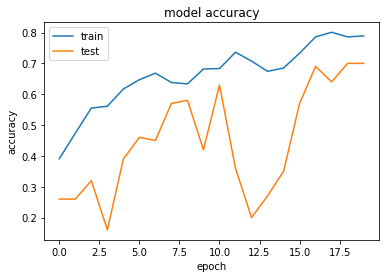

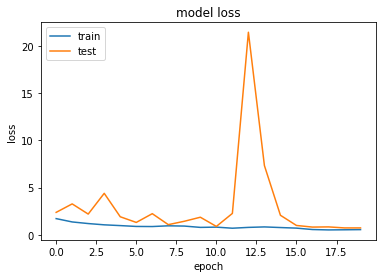

In [27]:
plot_loss_accuracy(history)

#### Experiment 5

In [28]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 15
# batch size = 10
# num_frames per video = 30
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_21 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_18 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                            

In [29]:
callbacks_list = model_callbacks("model_conv3D_5")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=True, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [31]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/15
67/67 [==============================] - ETA: 0s - loss: 1.7356 - categorical_accuracy: 0.4072
Epoch 00001: val_loss improved from inf to 3.22246, saving model to model_conv3D_5_2024-10-0205_58_50.750794/model-00001-1.73558-0.40724-3.22246-0.21000.h5
67/67 [==============================] - 182s 3s/step - loss: 1.7356 - categorical_accuracy: 0.4072 - val_loss: 3.2225 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/15
67/67 [==============================] - ETA: 0s - loss: 1.4570 - categorical_accuracy: 0.4585
Epoch 00002: val_loss did not improve from 3.22246
67/67 [==============================] - 181s 3s/step - loss: 1.4570 - categorical_accuracy: 0.4585 - val_loss: 6.9113 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/15
67/67 [==============================] - ETA: 0s - loss: 1.2695 - categorical_accuracy: 0.5098
Epoch 00003: val_loss did not improve from 3.22246
67/67 [==============================] - 185s 3s/step - loss: 1.2695 - categorical_accurac

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


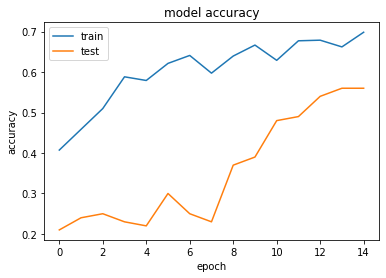

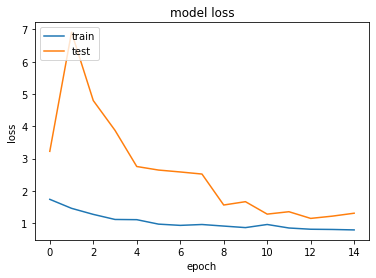

In [32]:
plot_loss_accuracy(history)

#### Experiment 6

In [13]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

conv_filters = (8, 16, 32, 64) 
model = conv3D(conv_filters, num_images=num_frames)
print (model.summary())

# epochs = 25
# batch size = 10
# num_frames per video = 30


2024-10-02 09:58:09.996656: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-10-02 09:58:09.996723: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11844 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 8)   656       
                                                                 
 activation (Activation)     (None, 30, 120, 120, 8)   0         
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 8)  32        
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 8)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 60, 60, 16)    3472      
                                                                 
 activation_1 (Activation)   (None, 15, 60, 60, 16)    0

In [14]:
callbacks_list = model_callbacks("model_conv3D_6")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [15]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25


2024-10-02 09:58:21.331397: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


67/67 [==============================] - ETA: 0s - loss: 1.6060 - categorical_accuracy: 0.3997
Epoch 00001: val_loss improved from inf to 2.51040, saving model to model_conv3D_6_2024-10-0209_57_43.141524/model-00001-1.60605-0.39970-2.51040-0.24000.h5
67/67 [==============================] - 177s 3s/step - loss: 1.6060 - categorical_accuracy: 0.3997 - val_loss: 2.5104 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 1.2448 - categorical_accuracy: 0.5219
Epoch 00002: val_loss did not improve from 2.51040
67/67 [==============================] - 164s 2s/step - loss: 1.2448 - categorical_accuracy: 0.5219 - val_loss: 2.9560 - val_categorical_accuracy: 0.3400 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 1.0152 - categorical_accuracy: 0.6003
Epoch 00003: val_loss did not improve from 2.51040
67/67 [==============================] - 156s 2s/step - loss: 1.0152 - categorical_accuracy: 0.6003 -

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


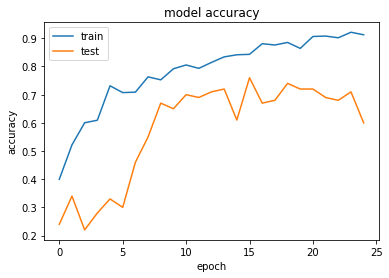

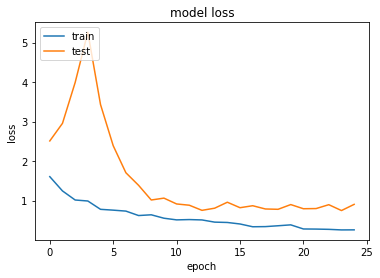

In [16]:
plot_loss_accuracy(history)

#### Experiment 7: TRANSFER LEARNING - MobileNet Conv2d + GRU

In [21]:
from tensorflow.keras.applications import mobilenet
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define the MobileNet + RNN Model
def mobilenet_RNN(fine_tune=False, gru=False, lstm_gru_cells=128, dense_nodes=128, dropout=0.25, num_images=20, height=120, width=120, num_classes=5):

    # Load pretrained MobileNet
    mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
    print("Number of layers in the pretrained MobileNet model: ", len(mobilenet_transfer.layers))

    # Fine-tuning if needed
    if fine_tune:
        fine_tune_at = 50  # Unfreeze layers from this point onward
        for layer in mobilenet_transfer.layers[:fine_tune_at]:
            layer.trainable = False

    # Define Sequential Model
    model = Sequential()

    # Wrap MobileNet with TimeDistributed to handle sequence input
    model.add(TimeDistributed(mobilenet_transfer, input_shape=(num_images, height, width, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    # Add RNN Layer
    if gru:
        model.add(GRU(lstm_gru_cells, return_sequences=False))
    else:
        model.add(LSTM(lstm_gru_cells, return_sequences=False))

    # Add Dense Layers with Dropout
    model.add(Dropout(dropout))
    model.add(Dense(dense_nodes, activation='relu'))
    model.add(Dropout(dropout))

    # Output Layer with Softmax Activation
    model.add(Dense(num_classes, activation='softmax'))

    # Compile Model with Adam Optimizer
    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model




In [22]:
# Model Parameters
num_epochs = 25
batch_size = 10
num_frames = 20
height = 120
width = 120
num_classes = 5
gru = True  # Set True for GRU, False for LSTM

# Initialize Model
model = mobilenet_RNN(fine_tune=True, gru=gru, lstm_gru_cells=128, dense_nodes=128, dropout=0.3, num_images=num_frames, height=height, width=width, num_classes=num_classes)

# Model Summary
print(model.summary())



Number of layers in the pretrained MobileNet model:  86
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 20, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 20, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
                                                                

In [23]:
# Callbacks for Model Optimization
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('model_best.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

callbacks_list = [early_stopping, checkpoint, reduce_lr]



In [24]:
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [40]:

# Fit the Model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks_list
)

Epoch 1/25
67/67 [==============================] - 118s 2s/step - loss: 1.6519 - categorical_accuracy: 0.2851 - val_loss: 1.2812 - val_categorical_accuracy: 0.5400 - lr: 1.0000e-04
Epoch 2/25
67/67 [==============================] - 114s 2s/step - loss: 1.1338 - categorical_accuracy: 0.5626 - val_loss: 1.0660 - val_categorical_accuracy: 0.6600 - lr: 1.0000e-04
Epoch 3/25
67/67 [==============================] - 116s 2s/step - loss: 0.7795 - categorical_accuracy: 0.7602 - val_loss: 0.7652 - val_categorical_accuracy: 0.7800 - lr: 1.0000e-04
Epoch 4/25
67/67 [==============================] - 114s 2s/step - loss: 0.6182 - categorical_accuracy: 0.7994 - val_loss: 0.7885 - val_categorical_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 5/25
67/67 [==============================] - 117s 2s/step - loss: 0.4466 - categorical_accuracy: 0.8627 - val_loss: 0.5317 - val_categorical_accuracy: 0.8300 - lr: 1.0000e-04
Epoch 6/25
67/67 [==============================] - 115s 2s/step - loss: 0.2849 - categori

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


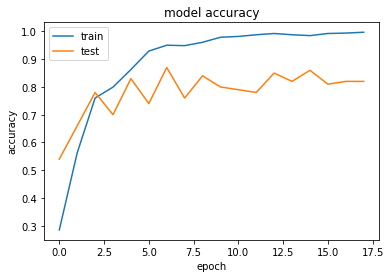

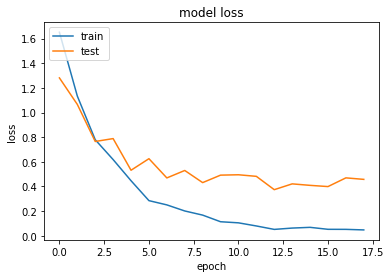

In [41]:
plot_loss_accuracy(history)

#### Experiment 8

In [25]:
# Initialize Model with LSTM
model = mobilenet_RNN(fine_tune=True, gru=False, lstm_gru_cells=128, dense_nodes=128, dropout=0.3, num_images=num_frames, height=height, width=width, num_classes=num_classes)

# Print model summary
print(model.summary())




Number of layers in the pretrained MobileNet model:  86
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
                                                                

In [26]:
# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks_list
)

Epoch 1/25
67/67 [==============================] - 118s 2s/step - loss: 1.6519 - categorical_accuracy: 0.2383 - val_loss: 1.5013 - val_categorical_accuracy: 0.3500 - lr: 1.0000e-04
Epoch 2/25
67/67 [==============================] - 109s 2s/step - loss: 1.3616 - categorical_accuracy: 0.4721 - val_loss: 1.2702 - val_categorical_accuracy: 0.6300 - lr: 1.0000e-04
Epoch 3/25
67/67 [==============================] - 108s 2s/step - loss: 1.1431 - categorical_accuracy: 0.5882 - val_loss: 0.9679 - val_categorical_accuracy: 0.7800 - lr: 1.0000e-04
Epoch 4/25
67/67 [==============================] - 107s 2s/step - loss: 0.7939 - categorical_accuracy: 0.7738 - val_loss: 0.8858 - val_categorical_accuracy: 0.6600 - lr: 1.0000e-04
Epoch 5/25
67/67 [==============================] - 109s 2s/step - loss: 0.5794 - categorical_accuracy: 0.8220 - val_loss: 0.5765 - val_categorical_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 6/25
67/67 [==============================] - 107s 2s/step - loss: 0.4348 - categori

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


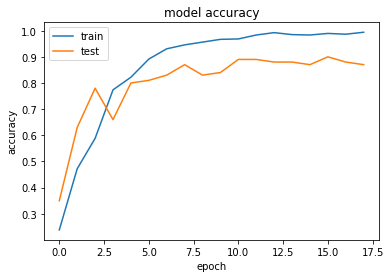

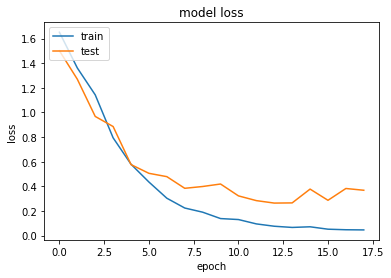

In [27]:
plot_loss_accuracy(history)

#### Experiment 9

In [28]:
def mobilenet_RNN(fine_tune=False, gru=False, lstm_gru_cells=128, dense_nodes=128, dropout=0.25, num_images=20, height=120, width=120):
    # Load MobileNet without its fully connected layer
    mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

    # If fine-tuning is enabled, freeze some layers
    if fine_tune:
        fine_tune_at = 50
        for layer in mobilenet_transfer.layers[:fine_tune_at]:
            layer.trainable = False

    model = Sequential()
    
    # Use TimeDistributed wrapper for processing frames with MobileNet
    model.add(TimeDistributed(mobilenet_transfer, input_shape=(num_images, height, width, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    
    # Add RNN layer (GRU or LSTM)
    if gru:
        model.add(GRU(lstm_gru_cells))
    else:
        model.add(LSTM(lstm_gru_cells))
    
    # Add dropout and dense layers for final classification
    model.add(Dropout(dropout))
    model.add(Dense(dense_nodes, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    opt = optimizers.Adam()
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    return model


In [29]:
# Callbacks for model saving and learning rate adjustment
model_name = 'model_mobilenet_RNN_' + str(datetime.datetime.now()).replace(' ', '_').replace(':', '_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{val_loss:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

callbacks_list = [checkpoint, reduce_lr, early_stopping]


In [30]:
# Initialize model
model = mobilenet_RNN(fine_tune=True, gru=True, lstm_gru_cells=128, dense_nodes=128, dropout=0.5, num_images=num_frames)

# Display model summary
print(model.summary())



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
                                                                 
 gru_2 (GRU)                 (None, 128)              

In [31]:
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [33]:
# Train the model
history = model.fit(
    train_generator,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks_list,
    verbose=1
)


Epoch 1/25
67/67 [==============================] - ETA: 0s - loss: 1.6438 - categorical_accuracy: 0.3725
Epoch 00001: val_loss improved from inf to 1.01065, saving model to model_mobilenet_RNN_2024-10-02_14_30_46.712864/model-00001-1.64375-1.01065.h5
67/67 [==============================] - 114s 2s/step - loss: 1.6438 - categorical_accuracy: 0.3725 - val_loss: 1.0107 - val_categorical_accuracy: 0.7000 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 1.0675 - categorical_accuracy: 0.5716
Epoch 00002: val_loss improved from 1.01065 to 0.61222, saving model to model_mobilenet_RNN_2024-10-02_14_30_46.712864/model-00002-1.06752-0.61222.h5
67/67 [==============================] - 111s 2s/step - loss: 1.0675 - categorical_accuracy: 0.5716 - val_loss: 0.6122 - val_categorical_accuracy: 0.7500 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 0.7345 - categorical_accuracy: 0.7044
Epoch 00003: val_loss improved from 0.61222 to 0.379

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


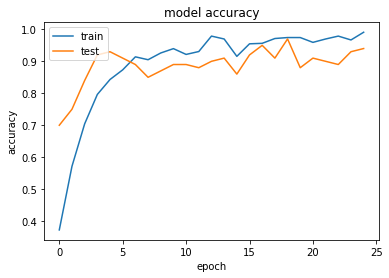

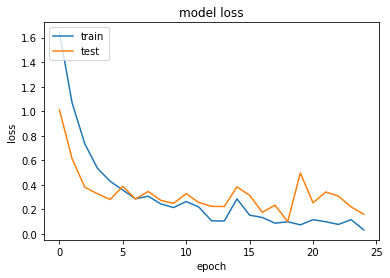

In [34]:
plot_loss_accuracy(history)

#### Summary of Observations
-	Initial Models: Models with basic 3D Convolution layers and varying input frame sizes showed stable performance, but struggled with overfitting in some cases.
-	Transfer Learning: Integrating MobileNet with RNN layers significantly improved both validation accuracy and loss. GRU and LSTM variants showed differences in convergence speed and performance.
-	Final Model: Fine-tuned MobileNet with GRU cells and adjusted dropout rates achieved the best results, indicating a successful balance between model complexity and generalization
